# Лабораторная работа №4 Методы снижения размерности. Регуляризация логистической регрессии.
## Вариант 9
## ПМИ3-1 Гущина Ольга
<p style="text-indent: 40px"><strong>Данные:</strong> winequalityred_for_lab</p>
<p style="text-indent: 40px"><strong>Зависимая переменная:</strong> Y</p>
<p style="text-indent: 40px"><strong>Объясняющие переменные:</strong></p>

<ul style="margin-left: 60px">
<li>fixed_acidity</li>
<li>volatile_acidity</li>
<li>citric_acid</li>
<li>residual_sugar</li>
<li>chlorides</li>
<li>free_sulfur_dioxide</li>
<li>total_sulfur_dioxide</li>
<li>density</li>
<li>pH</li>
<li>sulphates</li>
<li>alcohol</li>
</ul>

<p style="text-indent: 40px"><strong>Метод снижения размерности:</strong> PCR</p>
<p style="text-indent: 40px"><strong>Метод регуляризации:</strong> ридж-регрессия</p>

In [ ]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

my_seed = 9
plt = mpl.pyplot
sns.set_palette("Set2")

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [25]:
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3.):
   fig = plt.figure()
   ax = plt.subplot(111)
   # палитра
   colors = sns.color_palette("Spectral", len(col_names)-1)
   weights, params = [], []
   for c in np.arange(C_min_pow, C_max_pow+1):
     lr = LogisticRegression(penalty=penalty_name, C=10.**c, solver='liblinear', multi_class='ovr', random_state=my_seed)
     lr.fit(X, y)
     weights.append(lr.coef_[class_number])
     params.append(10**c)
     
   weights = np.array(weights)
   for column, color in zip(range(weights.shape[1]), colors):
     plt.plot(params, weights[:, column], label=col_names[column], color=color)

   # отсечки по оптимальным C
   plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=1)
   plt.axhline(0, color='black', linestyle='--', linewidth=1)
   plt.xlim([10**(C_min_pow), 10**C_max_pow])
   plt.ylabel('weight coefficient')
   plt.xlabel('C')
   plt.xscale('log')
   plt.legend(loc='upper left')
   ax.legend(loc='upper center',
             bbox_to_anchor=(1.38, 1.03),
             ncol=1, fancybox=True)
   plt.show()

In [26]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/winequality-red_for_lab.csv'
DF_all = pd.read_csv(fileURL)
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [27]:
#оставляем в наборе данных только столбцы по варианту
DF_all = DF_all[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']].copy()

In [79]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения (15%)
DF_predict = DF_all.drop(DF.index)
DF.iloc[:].head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
1472,7.6,0.350,0.60,2.6,0.073,23.0,44.0,0.99656,3.38,0.79,11.1,1
226,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,1
180,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,0
1264,8.5,0.370,0.32,1.8,0.066,26.0,51.0,0.99456,3.38,0.72,11.8,1
77,6.8,0.785,0.00,2.4,0.104,14.0,30.0,0.99660,3.52,0.55,10.7,1


In [29]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

In [30]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

Пропусков не обнаружено. Перейдём к предварительному анализу данных.

In [31]:
# метки классов
DF.Y.unique()

array([1, 0])

In [32]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

Y
1    0.539
0    0.461
Name: count, dtype: float64

Итак, всего целевых классов два, и их доли примерно одинаковы, с перевесом в пользу класса
'1'. Все объясняющие переменные набора данных непрерывные. Рассчитаем для них
описательные статистики.

In [33]:
# описательные статистики
DF.iloc[:].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Y
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.329948,0.529971,0.271347,2.556806,0.087935,15.675129,46.359455,0.996774,3.310074,0.657233,10.415379,0.539367
std,1.735247,0.177285,0.194011,1.458138,0.048734,10.322178,33.306026,0.001880,0.153493,0.172741,1.056220,0.498631
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.400000,0.095000,1.900000,0.070000,7.000000,22.000000,0.995645,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996760,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.430000,2.600000,0.090000,21.000000,61.000000,0.997800,3.400000,0.730000,11.000000,1.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


Выводы по описательным статистикам: Значения переменных измеряются в совершенно разных единицах и масштабах. Переменная Y является бинарной (принимает значения 0 или 1), что указывает на задачу бинарной классификации. Рекомендуется провести предобработку данных (стандартизацию).
Поскольку в наборе данных 11 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

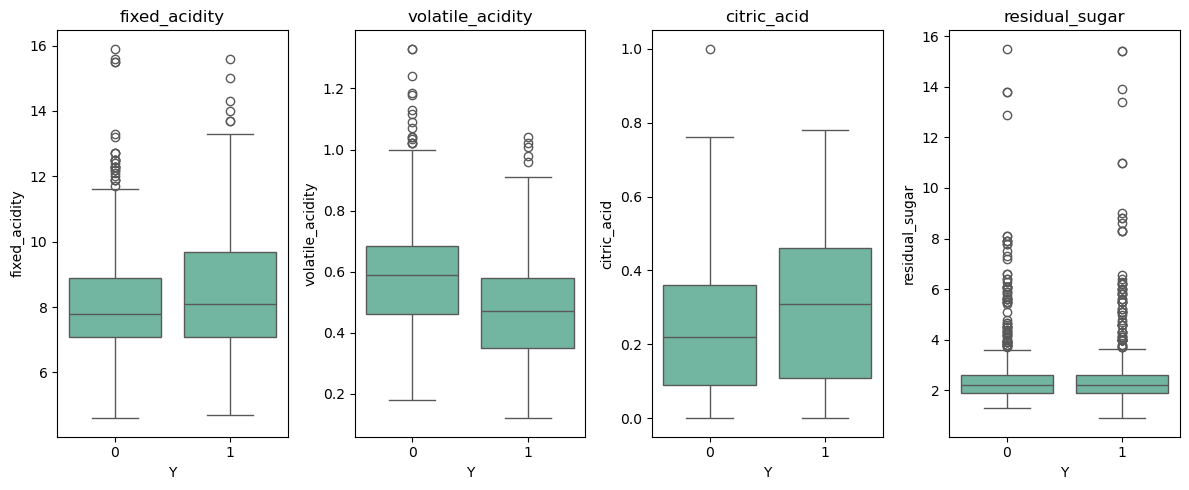

In [35]:
# создаём полотно и делим его на три части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[:4].values)
for col_name in cols_loop:
   i = cols_loop.index(col_name)
   sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
   axs[i].set_ylabel(col_name)
   axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

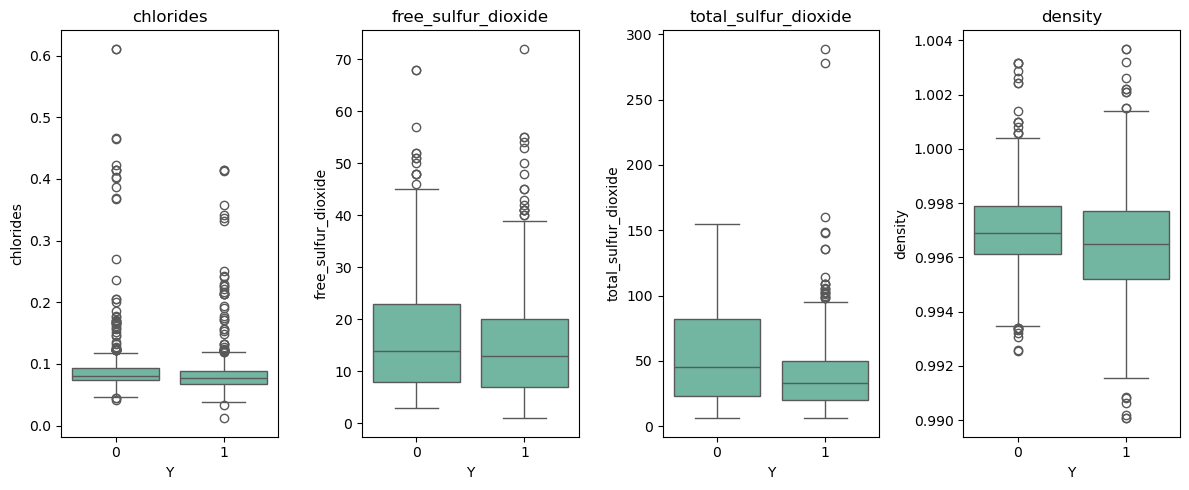

In [36]:
# создаём полотно и делим его на три части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[4:8].values)
for col_name in cols_loop:
   i = cols_loop.index(col_name)
   sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
   axs[i].set_ylabel(col_name)
   axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

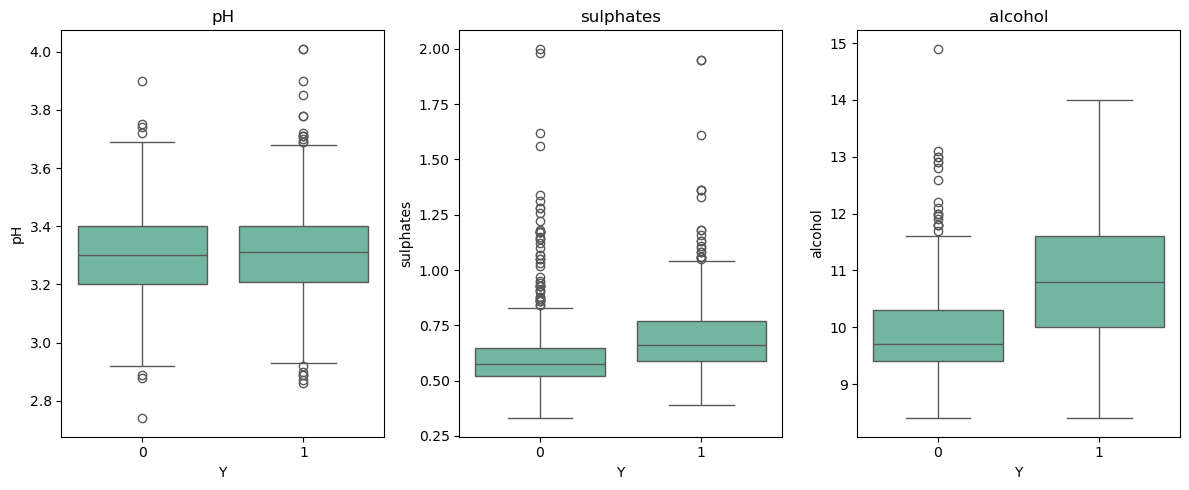

In [38]:
# создаём полотно и делим его на три части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

axs = [ax1, ax2, ax3]

cols_loop = list(DF.columns[8:11].values)
for col_name in cols_loop:
   i = cols_loop.index(col_name)
   sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
   axs[i].set_ylabel(col_name)
   axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках медианы практически не отличаются (значительное отличие прослеживается лишь в переменных "volatile_acidity", "citric_acid" и "alcohol" ). Классы разделяются не столько по средним значениям признаков, сколько по другим характеристикам распределения.
Теперь посмотрим на взаимодействие объясняющих переменных с помощью корреляционного анализа.

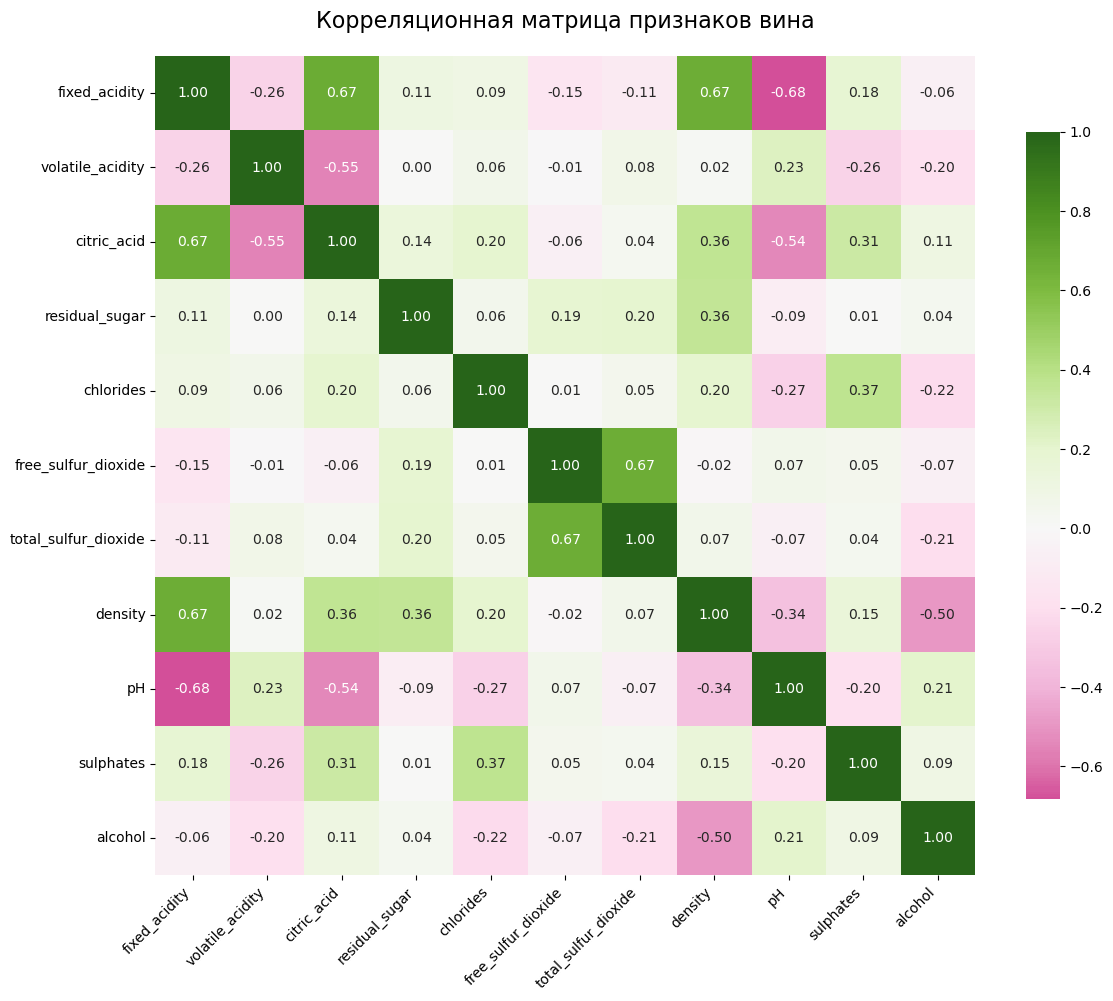

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# рисуем корреляционную матрицу с seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, 
            annot=True,           # показывать значения в ячейках
            cmap='PiYG',          # цветовая схема
            center=0,             # центр цветовой шкалы
            fmt='.2f',            # формат чисел (2 знака после запятой)
            square=True,          # квадратные ячейки
            cbar_kws={'shrink': 0.8})  # настройки цветовой шкалы

plt.title('Корреляционная матрица признаков вина', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.

In [47]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')


,Показатель_1,Показатель_2,Корреляция,P_значение
7,fixed_acidity,pH,-0.682978,0.0
10,volatile_acidity,citric_acid,-0.552496,0.0
24,citric_acid,pH,-0.541904,0.0
51,density,alcohol,-0.496180,0.0
49,density,pH,-0.341699,0.0
37,chlorides,pH,-0.265026,0.0
17,volatile_acidity,sulphates,-0.260987,0.0
0,fixed_acidity,volatile_acidity,-0.256131,0.0
39,chlorides,alcohol,-0.221141,0.0
48,total_sulfur_dioxide,alcohol,-0.205654,0.0


In [48]:
max_corr_row = df.loc[df['Корреляция'] == df['Корреляция'].max()]
print("МАКСИМАЛЬНАЯ положительная корреляция:")
print(f"{max_corr_row['Показатель_1'].values[0]} - {max_corr_row['Показатель_2'].values[0]}: {max_corr_row['Корреляция'].values[0]:.4f}")

МАКСИМАЛЬНАЯ положительная корреляция:
fixed_acidity - citric_acid: 0.6717


In [52]:
# Максимальная отрицательная корреляция
max_otr_corr_row = df.loc[df['Корреляция'] == df['Корреляция'].min()]
print("\nМАКСИМАЛЬНАЯ отрицательная корреляция:")
print(f"{max_otr_corr_row['Показатель_1'].values[0]} - {max_otr_corr_row['Показатель_2'].values[0]}: {max_otr_corr_row['Корреляция'].values[0]:.4f}")


МАКСИМАЛЬНАЯ отрицательная корреляция:
fixed_acidity - pH: -0.6830


In [54]:
# Минимальное значение корреляции
min_abs_idx = (df['Корреляция'].abs()).idxmin()
min_abs_corr_row = df.loc[min_abs_idx]

print("САМАЯ СЛАБАЯ корреляция (минимальная по модулю):")
print(f"{min_abs_corr_row['Показатель_1']} - {min_abs_corr_row['Показатель_2']}: {min_abs_corr_row['Корреляция']:.6f}")

САМАЯ СЛАБАЯ корреляция (минимальная по модулю):
volatile_acidity - residual_sugar: 0.001918


Теперь приступим к методу снижения размерности регрессии на главные компоненты (PCR) - по заданию варианта 9. Сначала следует провести стандартизацию данных.

In [55]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :13].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
 print('Столбец ', i_col, ': среднее = ',
 np.round(np.mean(X_train_std[:, i_col]), 2),
 ' Станд. отклонение = ',
 np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0 Станд. отклонение = 1.0
Столбец 1: среднее = 0.0 Станд. отклонение = 1.0
Столбец 2: среднее = -0.0 Станд. отклонение = 1.0
Столбец 3: среднее = -0.0 Станд. отклонение = 1.0
Столбец 4: среднее = 0.0 Станд. отклонение = 1.0
Столбец 5: среднее = -0.0 Станд. отклонение = 1.0
Столбец 6: среднее = 0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0
Столбец 8: среднее = 0.0 Станд. отклонение = 1.0
Столбец 9: среднее = 0.0 Станд. отклонение = 1.0
Столбец 10: среднее = 0.0 Станд. отклонение = 1.0
Столбец 11: среднее = 0.0 Станд. отклонение = 1.0


Пересчитаем объясняющие показатели в главные компоненты.

In [62]:
print("Столбцы в исходном DF:", DF.columns.tolist())
print("Форма исходного DF:", DF.shape)

from sklearn.preprocessing import StandardScaler

# Разделяем на признаки и целевую переменную
X = DF.drop('Y', axis=1)  # Все столбцы кроме Y
y = DF['Y']               # Только Y

# Стандартизируем только признаки
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X)  # Теперь это NumPy array без Y

print("Форма после стандартизации:", X_train_std.shape)

Столбцы в исходном DF: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'Y']
Форма исходного DF: (1599, 12)
Форма после стандартизации: (1599, 11)


In [63]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PCA:\n', np.around(frac_var_expl, 3),
      '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PCA:
 [0.282 0.175 0.141 0.11  0.087 0.06  0.053 0.038 0.031 0.016 0.005] 
Общая сумма долей: 1.0


In [64]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
1,-0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
3,-0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
4,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0
5,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0
6,-0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0
7,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,-0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0
9,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0


Доказано, что главные компоненты взаимно ортогональны. Теперь построим график объяснённой дисперсии.

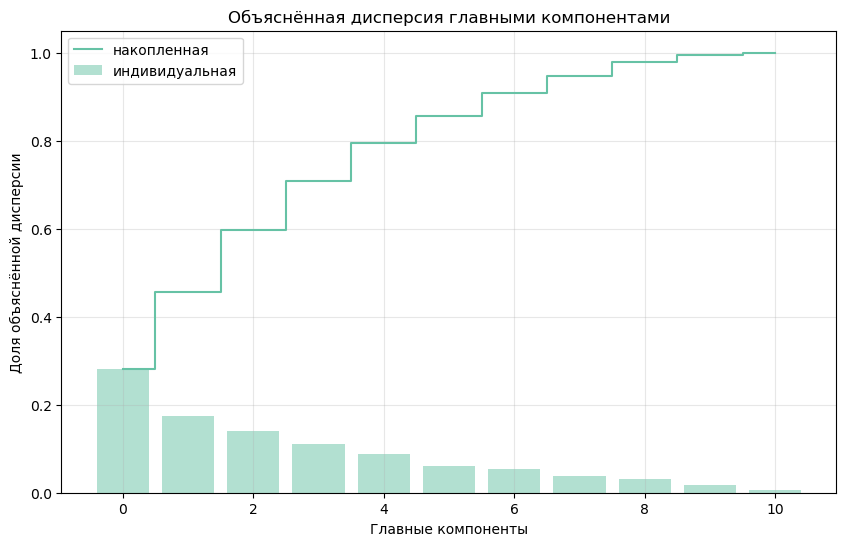

In [70]:
# график объяснённой дисперсии
n_components = len(pca.explained_variance_ratio_)  # автоматически определяем количество компонент

plt.figure(figsize=(10, 6))
plt.bar(range(0, n_components), pca.explained_variance_ratio_, alpha=0.5,
        align='center', label='индивидуальная')
plt.step(range(0, n_components), np.cumsum(pca.explained_variance_ratio_),
         where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Объяснённая дисперсия главными компонентами')
plt.show()


Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 5 компонент объясняют 85% исходной дисперсии X.

Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для двух компонент, которые объясняют 60% разброса объясняющих переменных.

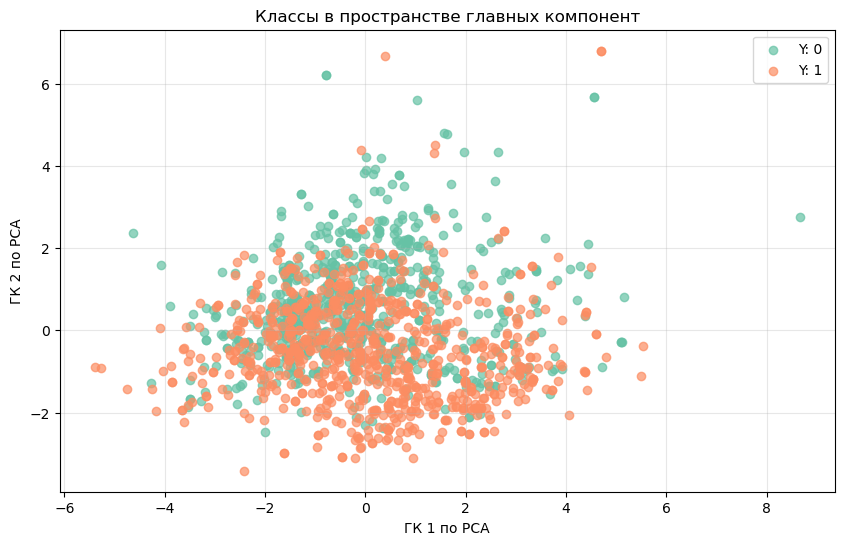

In [72]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], X_train_pca[DF['Y'] == 0][:, 1], 
            label='Y: 0', alpha=0.7)
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], X_train_pca[DF['Y'] == 1][:, 1], 
            label='Y: 1', alpha=0.7)
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.title('Классы в пространстве главных компонент')
plt.grid(True, alpha=0.3)
plt.show()

На графике заметно умеренное перекрытие классов, так как химические показатели вин разных классов часто пересекаются.

Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.

In [73]:
# функция оценки логистической регрессии
logit = LogisticRegression(random_state=my_seed)
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF['Y'].values, cv=kf_10,
                     scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 3), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.642


Модель показывает умеренное качество (Accuracy = 64.2%), что ненамного лучше случайного угадывания (50% для бинарной классификации). Модель логистической регрессии на двух главных компонентах показывает базовую разделительную способность (64.2% точности), что свидетельствует о наличии некоторых линейно разделимых закономерностей в данных, но для достижения более высокого качества классификации требуется использование большего количества признаков или более сложных моделей.

Тепеь используем для двух классов метод сжатия ридж-регрессия для 9 варианта.

In [76]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, DF['Y'])
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),'\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [0.239] 
Коэффициенты моделей для классов:
 [[ 0.236 -0.582 -0.241  0.079 -0.184  0.229 -0.535 -0.1   -0.056  0.472
   0.915]]


Подбираем гиперпараметр L(лямбда) регуляризации с помощью перекрёстной проверки.


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Заново разделим данные
X = DF.drop('Y', axis=1)
y = DF['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=my_seed, stratify=y
)

# Стандартизируем
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Теперь подберем C
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,
                               penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, y_train)
print("Оптимальные значения C:", ridge_cv.C_)


Оптимальные значения C: [0.04641589]


In [90]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[-1], ', перекрёстная проверка по 10 блокам', '\nAcc = ', score[2], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.734


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра C. Эта модель имеет только один набор коэффициентов, поскольку это бинарная классификация.

c:\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestCl

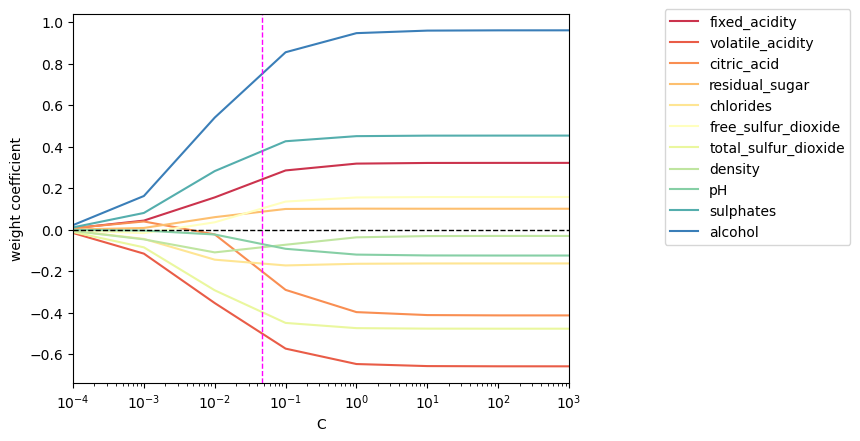

In [91]:
# график динамики коэффициентов в ридж-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, y_train, 0, 'l2', ridge_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется.

Ещё раз посмотрим на точность построенных моделей.

In [94]:
# Очищаем списки
score = []
score_models = []

# Добавляем модели по одной
score.append(0.642)  # logit_PC2
score_models.append('logit_PC2')

score.append(0.734)  # logit_ridge (только один раз!)
score_models.append('logit_ridge')

# сводка по точности моделей
pd.DataFrame({'Модель': score_models, 'Acc': score})

,Модель,Acc
0,logit_PC2,0.642
1,logit_ridge,0.734


**Лучшая модель: `logit_ridge`**

**Ключевые показатели:**
- Точность: 73.4%
- Улучшение: +9.2% по сравнению с PCA-моделью
- Качество: Умеренно-хорошее (против 50% случайного угадывания)

Ограничениe PCA-подхода - потеря 40% дисперсии при сокращении до 2 компонент

**Основная рекомендация:** использовать Ridge-регрессию - она показывает значительно лучшие результаты и более надежна для прогнозирования качества вина.

Сделаем прогноз на отложенные наблюдения.

In [100]:
# Правильное разделение данных
X_train = DF.drop('Y', axis=1)  # 11 признаков
y_train = DF['Y']

# Обучаем scaler на 11 признаках
sc_correct = StandardScaler()
X_train_std = sc_correct.fit_transform(X_train)

# Переобучаем модель на правильно стандартизированных данных
logit_ridge_correct = LogisticRegression(penalty='l2', solver='liblinear', random_state=my_seed)
logit_ridge_correct.fit(X_train_std, y_train)

# Теперь предсказываем на отложенной выборке
X_pred = DF_predict.drop('Y', axis=1)
X_pred_std = sc_correct.transform(X_pred)
Y_pred = DF_predict.Y
Y_hat = logit_ridge_correct.predict(X_pred_std)

print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       118
           1       0.73      0.80      0.76       122

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.75      0.75      0.75       240



Это хорошая, но не идеальная модель.

Accuracy: 75% - значительно лучше случайного угадывания (50%).

Сбалансированность: F1-score для обоих классов почти одинаковый (0.73 vs 0.76).

Стабильность: Нет сильного перекоса в precision/recall.

Модель работоспособна и надежна, но для критически важных применений можно улучшить до 80-85% точности. Для большинства бизнес-задач текущее качество вполне приемлемо.